# Tequila Chemistry Basics

Here we show the basics of the tequila chemistry module.  
In order for this to work you need to have psi4 installed in the same python environment as tequila.  
If you are in a conda environment installing psi4 is easy:
`conda install psi4 -c psi4`  
But better check the psi4 website for up to date instructions.

In some cases problems with the environment where enountered which are suspected to originate from conflicts between psi4 and tequila dependcies. Usually the safest way is to install psi4 **first** and then install tequila

Basic functionality is currently also provided with PySCF which might be easier to install. 

At the moment we only support closed-shell molecules

In [1]:
import tequila as tq

## Initialize Molecules

Molecules can be initialized by passing their geometries as string or the name of a `xyz` file.

In [2]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g")
print(molecule)

# lets also print some information about the orbitals
# we need it later

print("The Orbitals are:")
for orbital in molecule.orbitals:
    print(orbital)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
basis_set       : sto-3g          
geometry        : H 0.0 0.0 0.0
Li 0.0 0.0 1.6 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : molecule        

Psi4 Data
Point Group (full) : c_inf_v         
Point Group (used) : c2v             
nirrep          : 4 
irreps          : ['A1', 'A2', 'B1', 'B2'] 
mos per irrep   : [4, 0, 1, 1]    

The Orbitals are:
0 : 0A1 energy = -2.348839 
1 : 1A1 energy = -0.285276 
2 : 2A1 energy = +0.078216 
3 : 0B1 energy = +0.163950 
4 : 0B2 energy = +0.163950 
5 : 3A1 energy = +0.547769 


You can initialize a tequila `QubitHamiltonian` from a molecule with `make_hamiltonian`.
The standard transformation is the `jordan-wigner` transformation.  
You can use other transformations by initializing the molecule with the `transformation` keyword.

In [3]:
H = molecule.make_hamiltonian()
# the LiH Hamiltonian is already quite large, better not print the full thing
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


In [4]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="bravyi-kitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


## Setting active spaces

You can define active spaces on your molcule by passing down a dictionary of active orbitals.  
The orbitals are grouped into the irreducible representation of the underlying symmetry group (see the printout of `print(molecule)` above).

Lets take the LiH molecule from above but initialize it with an active space containing the second two A1 orbitals (meaning the first 0A1 orbital is frozen) and the B1 orbital

In [5]:
active_orbitals = {"A1":[1,2], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

active space not CAS type: frozen_uocc of A1  [3]
Hamiltonian has 62 terms


Lets make the active space even smaller, so that we can print out stuff in this tutorial

In [6]:
active_orbitals = {"A1":[1], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print(H)

active space not CAS type: frozen_uocc of A1  [2, 3]
Hamiltonian has 15 terms
-7.4711+0.1352Z(0)+0.1352Z(1)-0.0310Z(2)-0.0310Z(3)+0.1218Z(0)Z(1)+0.0059Y(0)X(1)X(2)Y(3)-0.0059Y(0)Y(1)X(2)X(3)-0.0059X(0)X(1)Y(2)Y(3)+0.0059X(0)Y(1)Y(2)X(3)+0.0617Z(0)Z(2)+0.0675Z(0)Z(3)+0.0675Z(1)Z(2)+0.0617Z(1)Z(3)+0.0782Z(2)Z(3)


## Computing classical methods with Psi4

We can use psi4 to compute the energies (and sometimes other quantities) with the `compute_energy` function.
Here are some examples. Note that the energies are computed within the active space if one is set.

Note also that not all active spaces can be represented by psi4 which will mean you can/should not use the classical psi4 methods with those (a warning will be printed). You will still get the right active space hamiltonian however.

Active spaces which will not work for psi4 methds are the ones where the orbitals of individual irreps are not in one block ( e.g. {`"A1":[1,3]`} )

In [7]:
mp2 = molecule.compute_energy(method="mp2")
mp3 = molecule.compute_energy(method="mp3")
cc2 = molecule.compute_energy(method="cc2")
ccsd = molecule.compute_energy(method="ccsd")
cisd = molecule.compute_energy(method="cisd")
fci = molecule.compute_energy(method="fci")

# for most coupled-cluster like models you can compute amplitudes
# Note that amplitudes are in closed-shell
amplitudes = molecule.compute_amplitudes("mp2")

# you can export a parameter dictionary which holds the indices of the amplitude as keys and values as values
# for this small active space that is only one amplitude for mp2
variables = amplitudes.make_parameter_dictionary()
print(variables)

# similar for ccsd since the singles are 0 due to symmetry (that changes if you change the active space)
amplitudes = molecule.compute_amplitudes("ccsd")
variables = amplitudes.make_parameter_dictionary()
print(variables)

{(1, 0, 1, 0): -0.026069395810974536}
{(1, 0, 1, 0): -0.027418022914682542}


## Hello World H2 optimization with LiH in an active space

Lets do a small hand-constructed VQE like it would be done for the Hydrogen molecule in STO-3G, just that we use our active space LiH molecule from the cell above.
For consistency reasons we initialize everything again.  

Check the `BasicUsage` and `SciPyOptimizers` tutorial notebooks for more information about then

In [8]:
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# define a hand designed circuit
U = tq.gates.Ry(angle="a", target=0) + tq.gates.X(target=[2,3])
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=0)
U += tq.gates.X(target=3, control=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))


active space not CAS type: frozen_uocc of A1  [2, 3]
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2 expectationvalues (min=2, max=2)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.197024007777559  angles= {a: 0.0}  samples= None
E= -7.197663726635509  angles= {a: -0.0234220027923584}  samples= None
E= -7.202037629758711  angles= {a: -0.11711001396179199}  samples= None
E= -7.247492279971124  angles= {a: -0.49186205863952637}  samples= None
E= -7.68640043833301  angles= {a: -1.9908702373504639}  samples= None
E= -7.59671569096237  angles= {a: -7.986902952194214}  samples= None
E= -7.862121739985101  angles= {a: -3.129600457337474}  samples= None
E= -7.598896929729115  angles= {a: -1.7104055550334691}  samples= None
E= -7.862681913900131  angles= {a: -3.0777237637496633}  samples= None
E= -7.862688897539096  a

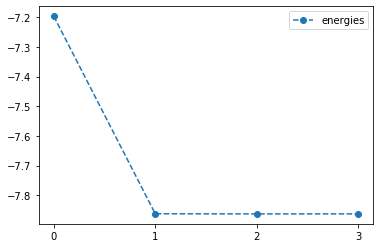

In [9]:
# some more information from the optimization
result.history.plot("energies", baselines={"fci":fci})

## Unitary Coupled-Cluster Style Construction

Here we show how to initialize in the style of unitary coupled-cluster.  
In this example we are gonna compute the `mp2` amplitudes and build a UCC type circuit from them.  
Here we use the cc2 amplitudes only to define an order on the trotterized gates and remove small amplitudes as classical prescreening.

We use again an active space to make the computation fast.

First we start with the manual construction and then show how to use in build convenience functions of tequila to.

An important function is the `make_excitation_generator` function of the molecule.  
This initializes a `QubitHamiltonian` which can be used to define a unitary gate which acts as excitation operation of electrons.

$$\displaystyle
U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

In fermionic language the generator is defined as

$$
G_{ia,jb,jc,\dots} =  i ( a^\dagger_a a_i a^\dagger_b a_j a^\dagger_c a_k \dots - h.c. )
$$

The `make_excitation_generator` function gives back this generator in the qubit representation (depends on the chosen `transformation` of the molecule) and takes the indices as list of tuples  
  
$$
\text{make_excitation_generator(indices=[(a,i),(b,j),...])} = G_{ia,jb,jc,\dots}
$$

### Manual Construction

In [10]:
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# compute classical amplitudes
amplitudes = molecule.compute_amplitudes(method="mp2")

# in this example there is only one closed-shell MP2 amplitude, therefore manual construction is reasonable in this tutorial
# first we make a dictionary out of the non-zero MP2 amplitudes
ampdict = amplitudes.make_parameter_dictionary(threshold=threshold)
print(ampdict)
# lets get the indices of the only amplitude which is there manually
indices = list(ampdict.keys())[0]

# the (1, 0, 1, 0) index in closed shell leads to the (2, 0, 3, 1) and (3, 1, 2, 0) excitations on the qubits
# but first we need to initialize the hartree fock state
U = molecule.prepare_reference()

# now add the two 2-electron excitations 
# for this we define the generators and build trotterized gates with them
# note that the two generators are actually the same
# we sum them up since we want to parametrize them with the same variable which we will call "a"
generator = molecule.make_excitation_generator(indices=[(3, 1),(2, 0)]) + molecule.make_excitation_generator(indices=[(3, 1),(2, 0)])
U += tq.gates.Trotterized(generators=[generators], angles=["a"], steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))



active space not CAS type: frozen_uocc of A1  [2, 3]
{(1, 0, 1, 0): -0.026069395810974536}


AttributeError: 'QuantumChemistryPsi4' object has no attribute 'make_excitation_generator'

### Automatic Construction

In [11]:
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
    
    

active space not CAS type: frozen_uocc of A1  [2, 3]
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 32 expectationvalues (min=32, max=32)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.861864768775314  angles= {(1, 0, 1, 0): 0.0}  samples= None
E= -7.862598093888588  angles= {(1, 0, 1, 0): -0.0468440055847168}  samples= None
E= -7.862688897514223  angles= {(1, 0, 1, 0): -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
VQE : -7.8626889f
FCI : -7.8823244f


### Pi System of Benzene
Lets repeat the last cell with the pi system of the benzene molecule

In [12]:
active = {"B1u": [0], "B3g": [0, 1], "B2g": [0], "Au": [0], "b1u": [1]}
molecule = tq.quantumchemistry.Molecule(geometry="data/benzene.xyz", basis_set='sto-3g', active_orbitals=active)
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", gradient="2-point", method_options={"eps":1.e-3}, initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))

active space not CAS type: frozen_uocc of AG  [6, 7, 8]
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2-point
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
21 active variables
E= -227.88792153297504  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.88792153297504  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0

E= -227.8877269810726  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.001, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.88764804085437  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.001, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.88780888037763  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1):

E= -227.12054392774883  angles= {(3, 0, 5, 2): 0.15726954464412302, (3, 2, 5, 0): 0.035453098377047354, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530087911940427, (5, 0, 5, 0): -0.08811814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3540087911940427, (4, 1, 5, 0): -0.040397662246505206, (3, 2, 4, 1): -0.2734921206695162, (5, 1, 4, 0): -0.16205486414833103, (5, 0, 4, 1): -0.040397662246505206, (5, 0, 3, 2): 0.035453098377047354, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.15726954464412302, (4, 1, 4, 1): -0.19453929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734921206695162, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205486414833103}  samples= None
E= -227.12039490036028  angles= {(3, 0, 5, 2): 0.15726954464412302, (3, 2, 5, 0): 0.035453098377047354, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530087911940427, (5, 0, 5, 0): -0.08811814404

E= -227.12117512993854  angles= {(3, 0, 5, 2): 0.15726954464412302, (3, 2, 5, 0): 0.035453098377047354, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530087911940427, (5, 0, 5, 0): -0.08811814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530087911940427, (4, 1, 5, 0): -0.040397662246505206, (3, 2, 4, 1): -0.2734921206695162, (5, 1, 4, 0): -0.16205486414833103, (5, 0, 4, 1): -0.040397662246505206, (5, 0, 3, 2): 0.035453098377047354, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.15726954464412302, (4, 1, 4, 1): -0.19453929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2724921206695162, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205486414833103}  samples= None
E= -227.120814382835  angles= {(3, 0, 5, 2): 0.15726954464412302, (3, 2, 5, 0): 0.035453098377047354, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530087911940427, (5, 0, 5, 0): -0.0881181440490

E= -227.92475660689158  angles= {(3, 0, 5, 2): 0.017406524989968003, (3, 2, 5, 0): 0.003923933551586904, (5, 2, 5, 2): -0.012736799079259434, (4, 2, 3, 1): 0.03907085990171791, (5, 0, 5, 0): -0.009752877964584133, (3, 1, 3, 1): -0.011342862053973411, (3, 1, 4, 2): 0.03907085990171791, (4, 1, 5, 0): -0.004471195736092931, (3, 2, 4, 1): -0.030269989296183637, (5, 1, 4, 0): -0.017936162077195943, (5, 0, 4, 1): -0.004471195736092931, (5, 0, 3, 2): 0.003923933551586904, (4, 0, 4, 0): -0.012468671630982841, (5, 2, 3, 0): 0.017406524989968003, (4, 1, 4, 1): -0.021531524652530182, (4, 2, 4, 2): -0.012342977331386224, (3, 2, 3, 2): -0.02153292018051812, (4, 1, 3, 2): -0.030269989296183637, (3, 0, 3, 0): -0.012468340621294455, (5, 1, 5, 1): -0.012736964077645529, (4, 0, 5, 1): -0.017936162077195943}  samples= None
E= -227.92471538519132  angles= {(3, 0, 5, 2): 0.017406524989968003, (3, 2, 5, 0): 0.003923933551586904, (5, 2, 5, 2): -0.012736799079259434, (4, 2, 3, 1): 0.03907085990171791, (5, 0, 

E= -227.92463715181  angles= {(3, 0, 5, 2): 0.017406524989968003, (3, 2, 5, 0): 0.003923933551586904, (5, 2, 5, 2): -0.012736799079259434, (4, 2, 3, 1): 0.03907085990171791, (5, 0, 5, 0): -0.009752877964584133, (3, 1, 3, 1): -0.012342862053973412, (3, 1, 4, 2): 0.03907085990171791, (4, 1, 5, 0): -0.004471195736092931, (3, 2, 4, 1): -0.030269989296183637, (5, 1, 4, 0): -0.017936162077195943, (5, 0, 4, 1): -0.004471195736092931, (5, 0, 3, 2): 0.003923933551586904, (4, 0, 4, 0): -0.012468671630982841, (5, 2, 3, 0): 0.017406524989968003, (4, 1, 4, 1): -0.021531524652530182, (4, 2, 4, 2): -0.012342977331386224, (3, 2, 3, 2): -0.020532920180518117, (4, 1, 3, 2): -0.030269989296183637, (3, 0, 3, 0): -0.012468340621294455, (5, 1, 5, 1): -0.012736964077645529, (4, 0, 5, 1): -0.017936162077195943}  samples= None
E= -227.9250134984032  angles= {(3, 0, 5, 2): 0.017406524989968003, (3, 2, 5, 0): 0.003923933551586904, (5, 2, 5, 2): -0.012736799079259434, (4, 2, 3, 1): 0.03907085990171791, (5, 0, 5, 

E= -227.97636758661082  angles= {(3, 0, 5, 2): 0.05342151231446252, (3, 2, 5, 0): 0.039266708498101106, (5, 2, 5, 2): -0.04653807342897462, (4, 2, 3, 1): 0.05250491881462646, (5, 0, 5, 0): -0.04064961564005923, (3, 1, 3, 1): -0.038891106957557195, (3, 1, 4, 2): 0.052612863614414744, (4, 1, 5, 0): -0.04185924672300246, (3, 2, 4, 1): -0.0024837450403163847, (5, 1, 4, 0): -0.055307496645340445, (5, 0, 4, 1): -0.04188328846724335, (5, 0, 3, 2): 0.0392888204332613, (4, 0, 4, 0): -0.04651181036526961, (5, 2, 3, 0): 0.053430313743658565, (4, 1, 4, 1): -0.09136767468877023, (4, 2, 4, 2): -0.03889220929852233, (3, 2, 3, 2): -0.09106581806633124, (4, 1, 3, 2): -0.002302801592419003, (3, 0, 3, 0): -0.04640278788834948, (5, 1, 5, 1): -0.046641100167116964, (4, 0, 5, 1): -0.055299094059890315}  samples= None
E= -227.97638323472438  angles= {(3, 0, 5, 2): 0.05342151231446252, (3, 2, 5, 0): 0.039266708498101106, (5, 2, 5, 2): -0.04653807342897462, (4, 2, 3, 1): 0.05250491881462646, (5, 0, 5, 0): -0.0

E= -227.97638321488458  angles= {(3, 0, 5, 2): 0.05342151231446252, (3, 2, 5, 0): 0.039266708498101106, (5, 2, 5, 2): -0.04653807342897462, (4, 2, 3, 1): 0.05250491881462646, (5, 0, 5, 0): -0.04164961564005923, (3, 1, 3, 1): -0.038891106957557195, (3, 1, 4, 2): 0.052612863614414744, (4, 1, 5, 0): -0.04185924672300246, (3, 2, 4, 1): -0.0024837450403163847, (5, 1, 4, 0): -0.055307496645340445, (5, 0, 4, 1): -0.04188328846724335, (5, 0, 3, 2): 0.0392888204332613, (4, 0, 4, 0): -0.04651181036526961, (5, 2, 3, 0): 0.053430313743658565, (4, 1, 4, 1): -0.09136767468877023, (4, 2, 4, 2): -0.03789220929852233, (3, 2, 3, 2): -0.09106581806633124, (4, 1, 3, 2): -0.002302801592419003, (3, 0, 3, 0): -0.04640278788834948, (5, 1, 5, 1): -0.046641100167116964, (4, 0, 5, 1): -0.055299094059890315}  samples= None
E= -227.97628636449346  angles= {(3, 0, 5, 2): 0.05342151231446252, (3, 2, 5, 0): 0.039266708498101106, (5, 2, 5, 2): -0.04653807342897462, (4, 2, 3, 1): 0.05250491881462646, (5, 0, 5, 0): -0.0

E= -227.9750292949219  angles= {(3, 0, 5, 2): 0.07479503718384001, (3, 2, 5, 0): 0.0942279864902676, (5, 2, 5, 2): -0.021456495277732142, (4, 2, 3, 1): 0.12209645167935765, (5, 0, 5, 0): -0.04333824460757034, (3, 1, 3, 1): -0.028035795583082498, (3, 1, 4, 2): 0.12092184880392179, (4, 1, 5, 0): -0.08541877758408764, (3, 2, 4, 1): 0.056573618737835965, (5, 1, 4, 0): -0.07917492151650922, (5, 0, 4, 1): -0.08567351117049746, (5, 0, 3, 2): 0.09448309442065524, (4, 0, 4, 0): -0.03966420236256828, (5, 2, 3, 0): 0.07504822110883415, (4, 1, 4, 1): -0.20998745150217263, (4, 2, 4, 2): -0.02806812525087538, (3, 2, 3, 2): -0.20531951010324284, (4, 1, 3, 2): 0.05749880092038323, (3, 0, 3, 0): -0.03576271573889534, (5, 1, 5, 1): -0.025056230385280317, (4, 0, 5, 1): -0.0790092215513154}  samples= None
E= -227.97508365876138  angles= {(3, 0, 5, 2): 0.07479503718384001, (3, 2, 5, 0): 0.0942279864902676, (5, 2, 5, 2): -0.021456495277732142, (4, 2, 3, 1): 0.12109645167935765, (5, 0, 5, 0): -0.042338244607

E= -227.97515849126117  angles= {(3, 0, 5, 2): 0.07479503718384001, (3, 2, 5, 0): 0.0942279864902676, (5, 2, 5, 2): -0.021456495277732142, (4, 2, 3, 1): 0.12109645167935765, (5, 0, 5, 0): -0.04333824460757034, (3, 1, 3, 1): -0.028035795583082498, (3, 1, 4, 2): 0.12092184880392179, (4, 1, 5, 0): -0.08541877758408764, (3, 2, 4, 1): 0.056573618737835965, (5, 1, 4, 0): -0.07917492151650922, (5, 0, 4, 1): -0.08567351117049746, (5, 0, 3, 2): 0.09448309442065524, (4, 0, 4, 0): -0.03966420236256828, (5, 2, 3, 0): 0.07504822110883415, (4, 1, 4, 1): -0.20898745150217263, (4, 2, 4, 2): -0.02806812525087538, (3, 2, 3, 2): -0.20531951010324284, (4, 1, 3, 2): 0.05749880092038323, (3, 0, 3, 0): -0.03576271573889534, (5, 1, 5, 1): -0.025056230385280317, (4, 0, 5, 1): -0.0790092215513154}  samples= None
E= -227.97512272023974  angles= {(3, 0, 5, 2): 0.07479503718384001, (3, 2, 5, 0): 0.0942279864902676, (5, 2, 5, 2): -0.021456495277732142, (4, 2, 3, 1): 0.12109645167935765, (5, 0, 5, 0): -0.04333824460

E= -227.987497951971  angles= {(3, 0, 5, 2): 0.06379397262490366, (3, 2, 5, 0): 0.06593913048132044, (5, 2, 5, 2): -0.03336611417157921, (4, 2, 3, 1): 0.0857920325040993, (5, 0, 5, 0): -0.04246909848398007, (3, 1, 3, 1): -0.03362308087962471, (3, 1, 4, 2): 0.08576285838854812, (4, 1, 5, 0): -0.06299846020132666, (3, 2, 4, 1): 0.026176486043318202, (5, 1, 4, 0): -0.06689023363896224, (5, 0, 4, 1): -0.06313445549517921, (5, 0, 3, 2): 0.06607431415957205, (4, 0, 4, 0): -0.043188701862411444, (5, 2, 3, 0): 0.06392137160661965, (4, 1, 4, 1): -0.14893323463032226, (4, 2, 4, 2): -0.033639337679674225, (3, 2, 3, 2): -0.14651253980347198, (4, 1, 3, 2): 0.02671860467330775, (3, 0, 3, 0): -0.041239216285400414, (5, 1, 5, 1): -0.03616607527129772, (4, 0, 5, 1): -0.06680549545429303}  samples= None
E= -227.98746959606925  angles= {(3, 0, 5, 2): 0.06379397262490366, (3, 2, 5, 0): 0.06593913048132044, (5, 2, 5, 2): -0.03436611417157921, (4, 2, 3, 1): 0.0867920325040993, (5, 0, 5, 0): -0.0424690984839

E= -227.98766857944045  angles= {(3, 0, 5, 2): 0.06379397262490366, (3, 2, 5, 0): 0.06593913048132044, (5, 2, 5, 2): -0.03436611417157921, (4, 2, 3, 1): 0.0857920325040993, (5, 0, 5, 0): -0.04246909848398007, (3, 1, 3, 1): -0.03362308087962471, (3, 1, 4, 2): 0.08576285838854812, (4, 1, 5, 0): -0.06299846020132666, (3, 2, 4, 1): 0.026176486043318202, (5, 1, 4, 0): -0.06689023363896224, (5, 0, 4, 1): -0.06313445549517921, (5, 0, 3, 2): 0.06607431415957205, (4, 0, 4, 0): -0.043188701862411444, (5, 2, 3, 0): 0.06492137160661965, (4, 1, 4, 1): -0.14893323463032226, (4, 2, 4, 2): -0.033639337679674225, (3, 2, 3, 2): -0.14651253980347198, (4, 1, 3, 2): 0.02671860467330775, (3, 0, 3, 0): -0.041239216285400414, (5, 1, 5, 1): -0.03616607527129772, (4, 0, 5, 1): -0.06680549545429303}  samples= None
E= -227.9874881096204  angles= {(3, 0, 5, 2): 0.06379397262490366, (3, 2, 5, 0): 0.06593913048132044, (5, 2, 5, 2): -0.03436611417157921, (4, 2, 3, 1): 0.0857920325040993, (5, 0, 5, 0): -0.042469098483

E= -227.98999555724953  angles= {(3, 0, 5, 2): 0.09861291114228783, (3, 2, 5, 0): 0.0685005272262645, (5, 2, 5, 2): -0.023107213161559944, (4, 2, 3, 1): 0.11605000283704622, (5, 0, 5, 0): -0.045534592363031305, (3, 1, 3, 1): -0.02623661719827492, (3, 1, 4, 2): 0.11577791808156138, (4, 1, 5, 0): -0.0672098926358886, (3, 2, 4, 1): 0.06648377879053403, (5, 1, 4, 0): -0.09422817727445218, (5, 0, 4, 1): -0.06738640474937171, (5, 0, 3, 2): 0.06762205192054682, (4, 0, 4, 0): -0.0393716592902964, (5, 2, 3, 0): 0.09873895086343643, (4, 1, 4, 1): -0.21171009788768963, (4, 2, 4, 2): -0.026244962269898184, (3, 2, 3, 2): -0.2066914222539018, (4, 1, 3, 2): 0.06755356257389353, (3, 0, 3, 0): -0.03644710811107193, (5, 1, 5, 1): -0.025656193424502823, (4, 0, 5, 1): -0.0941454152539048}  samples= None
E= -227.98988155255196  angles= {(3, 0, 5, 2): 0.09861291114228783, (3, 2, 5, 0): 0.0675005272262645, (5, 2, 5, 2): -0.022107213161559943, (4, 2, 3, 1): 0.11605000283704622, (5, 0, 5, 0): -0.04553459236303

E= -227.98990457563087  angles= {(3, 0, 5, 2): 0.09861291114228783, (3, 2, 5, 0): 0.0675005272262645, (5, 2, 5, 2): -0.023107213161559944, (4, 2, 3, 1): 0.11605000283704622, (5, 0, 5, 0): -0.045534592363031305, (3, 1, 3, 1): -0.02623661719827492, (3, 1, 4, 2): 0.11577791808156138, (4, 1, 5, 0): -0.0672098926358886, (3, 2, 4, 1): 0.06648377879053403, (5, 1, 4, 0): -0.09422817727445218, (5, 0, 4, 1): -0.06738640474937171, (5, 0, 3, 2): 0.06762205192054682, (4, 0, 4, 0): -0.0383716592902964, (5, 2, 3, 0): 0.09873895086343643, (4, 1, 4, 1): -0.21171009788768963, (4, 2, 4, 2): -0.026244962269898184, (3, 2, 3, 2): -0.2066914222539018, (4, 1, 3, 2): 0.06755356257389353, (3, 0, 3, 0): -0.03644710811107193, (5, 1, 5, 1): -0.025656193424502823, (4, 0, 5, 1): -0.0941454152539048}  samples= None
E= -227.98978468772327  angles= {(3, 0, 5, 2): 0.09861291114228783, (3, 2, 5, 0): 0.0675005272262645, (5, 2, 5, 2): -0.023107213161559944, (4, 2, 3, 1): 0.11605000283704622, (5, 0, 5, 0): -0.04553459236303

E= -227.99288172583366  angles= {(3, 0, 5, 2): 0.09200966149188126, (3, 2, 5, 0): 0.06290124391780502, (5, 2, 5, 2): -0.032635755532409896, (4, 2, 3, 1): 0.11541132871228432, (5, 0, 5, 0): -0.06243948572447636, (3, 1, 3, 1): -0.028776772342070083, (3, 1, 4, 2): 0.11511911022814564, (4, 1, 5, 0): -0.06583021604636684, (3, 2, 4, 1): 0.06527721852308467, (5, 1, 4, 0): -0.08474514088000826, (5, 0, 4, 1): -0.06607687744047303, (5, 0, 3, 2): 0.0631093450139079, (4, 0, 4, 0): -0.04153095842273982, (5, 2, 3, 0): 0.09119590104479493, (4, 1, 4, 1): -0.20535993011568762, (4, 2, 4, 2): -0.02870519020016012, (3, 2, 3, 2): -0.20143637706009804, (4, 1, 3, 2): 0.06634809060407326, (3, 0, 3, 0): -0.040230639471168644, (5, 1, 5, 1): -0.03349089149398531, (4, 0, 5, 1): -0.08463240873923933}  samples= None
E= -227.99305240385766  angles= {(3, 0, 5, 2): 0.09100966149188126, (3, 2, 5, 0): 0.06390124391780502, (5, 2, 5, 2): -0.032635755532409896, (4, 2, 3, 1): 0.11541132871228432, (5, 0, 5, 0): -0.0624394857

KeyboardInterrupt: 